In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy.io as io

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold, StratifiedKFold

import sys
from IPython.display import clear_output

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

def verbose(text):    
    clear_output(wait=True)    
    print(text)
    sys.stdout.flush() 
    
def errorfill(x, y, yerr, color=None, label=None, alpha_fill=0.3, ax=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.get_next_color()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    ax.plot(x, y, color=color, label=label)
    ax.fill_between(x, ymax, ymin, color=color, label=label, alpha=alpha_fill)
    return ax

In [2]:
baseMethods=['','baseline50','baseline100']
baseMethod=baseMethods[1]

#read only what is needed. If you don't need individ. trials, use X_all, not ERPs to use less memory
files=['ERPs','X_all','results-8x1','results-8x4'] # load avgERPs for avg trials for less memory usage 
f=1
filename = files[f]+'-'+baseMethod+'.npz'

directory = '/home/data/Project_ASD/' + os.environ["USER"]+'/'
data = np.load(directory+filename, allow_pickle=True)

if f==0:
    ERPs=data['ERPs'] # n_subj, n_trtype, n_conds
elif f==1:
    X_all = data['X_all'] #n_trtype, n_conds,n_subj, n_time, n_elec 
    subjects = data['subjects']
    n_trtype, n_conds,n_subj, n_time, n_elec = X_all.shape
elif f==2:
    search_all=data['search_all']
    bestScores=data['bestScores']

trialTypes=['item1','item2','target','invalidThird','correct','catch','easyFiller','ctrlFiller'];


In [3]:
#subj2exclude=['10056','12144','12360','1160','12005']
subj2exclude=['10594']
ind_ex = [i for i in range(subjects.shape[0]) if subjects[i,2] in subj2exclude]

X_all = np.delete(X_all, ind_ex, axis=2)
subjects = np.delete(subjects, ind_ex, axis=0)
print('Removed '+str(len(ind_ex))+' subjects')

if subjects.shape[0]!= print(X_all.shape)[2]:
    print('Error! Subject size does not match to the data')

Removed 0 subjects
(38, 3)
(8, 4, 38, 122, 160)


In [16]:
test_pca1 = np.array([32])#np.arange(5,38,5)#np.array([15,38])#
test_pca2 = np.arange(2,n_subj,3) 
test_pca3 = np.array([15,38])

test_C1 =np.logspace(-5, 0, 6)
test_C2=np.logspace(-3, 0, 21)  #-3, 0, 41) 


In [38]:
pca = PCA()
test_pca=test_pca2
test_C=test_C2

clfs={}

clfs['LR-L2']= LogisticRegression(max_iter=5000, tol=1.0) #default=’l2’
clfs['LR-L1']= LogisticRegression(penalty='l1', solver='liblinear', max_iter=5000, tol=1.0)
clfs['LDA']=  LinearDiscriminantAnalysis(tol=1e-3)
clfs['QDA'] = QuadraticDiscriminantAnalysis(tol=1e-3)


In [42]:
clf_key_8x4='LR-L2'
pipe_8x4 = Pipeline(steps=[('pca', pca), ('clf', clfs[clf_key_8x4])])

clf_key_8x1='LR-L2'
pipe_8x1 = Pipeline(steps=[('pca', pca), ('clf', clfs[clf_key_8x1])])

param_grid = {'pca__n_components': test_pca,'clf__C': test_C}

print('Testing '+ str(param_grid['pca__n_components'].shape[0]) +' different n_pca and '+str(param_grid['clf__C'].shape[0]) +' regularization parameters')


Testing 12 different n_pca and 21 regularization parameters


In [20]:
y=subjects[...,0]

In [21]:
search_8x4 = np.zeros((n_trtype,n_conds), dtype=object)
for i in range(n_trtype):
    for j in range(n_conds):
        X = X_all[i,j].reshape(n_subj,n_time*n_elec)**2        
        #X -= X.mean(0, keepdims=True)
        # /= X.std(0, keepdims=True)
        search_8x4[i,j] = GridSearchCV(pipe_8x4, param_grid, cv=5, n_jobs=15, verbose=0)
        search_8x4[i,j].fit(X, y);
        verbose('%i,%i'%(i,j))



7,3


In [22]:
search_8x1 = np.zeros(n_trtype, dtype=object)
for i in range(n_trtype):
    X = X_all[i].reshape(n_subj,n_time*n_elec*n_conds)
    search_8x1[i] = GridSearchCV(pipe_8x1, param_grid, cv=5, n_jobs=15, verbose=0)
    search_8x1[i].fit(X, y);
    verbose('%i'%(i))
    

7


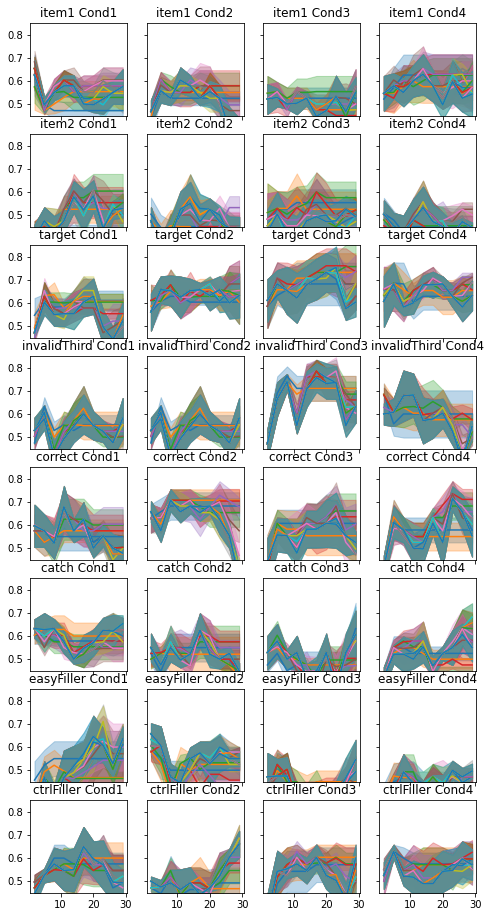

In [23]:
fig, ax = plt.subplots(n_trtype,n_conds,figsize=(n_conds*2,n_trtype*2),sharey=True,sharex=True)
for i in range(n_trtype):
    for j in range(n_conds):
        #print("Best parameter (CV score=%0.3f):" % search_all[i,j].best_score_)
        #print(search_all[i,j].best_params_)
        clf_key_8x4='LR-L2'
        if clf_key_8x4 in ['LR-L1','LR-L2']
            for k in range(test_C.shape[0]):
                errorfill(test_pca,search_8x4[i,j].
                          cv_results_['mean_test_score']
                          .reshape(test_C.shape[0],test_pca.shape[0])[k].T,
                          search_8x4[i,j].cv_results_['std_test_score']
                          .reshape(test_C.shape[0],test_pca.shape[0])[k].T
                              /np.sqrt(5), ax=ax[i,j])
                ax[i,j].set_ylim(0.45,0.85)
                ax[i,j].title.set_text(trialTypes[i]+' '+'Cond'+str(j+1))
            
        else:
            errorfill(test_pca,search_8x4[i,j].cv_results_['mean_test_score'],
                      search_8x4[i,j].cv_results_['std_test_score']/np.sqrt(5),
                      ax=ax[i,j])    
        ax[i,j].set_ylim(0.45,0.85)
        


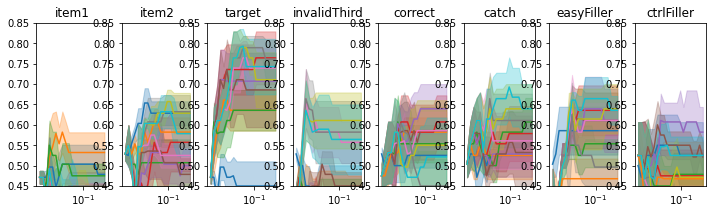

In [24]:
fig, ax = plt.subplots(1, n_trtype, figsize=(12,3))
for i in range(n_trtype):
    #print("Best parameter (CV score=%0.3f):" % search_8x1[i].best_score_)
    #print(search_8x1[i].best_params_)
    for k in range(test_pca.shape[0]):
        errorfill(test_C,search_8x1[i].
                  cv_results_['mean_test_score']
                  .reshape(test_C.shape[0],test_pca.shape[0])[:,k],
                  search_8x1[i].cv_results_['std_test_score']
                  .reshape(test_C.shape[0],test_pca.shape[0])[:,k]/np.sqrt(5),
                  ax=ax[i])

    ax[i].set_xscale('log')
    ax[i].set_ylim(0.45,0.85)
    ax[i].title.set_text(trialTypes[i])


0
2
4
0
0
5
4
0


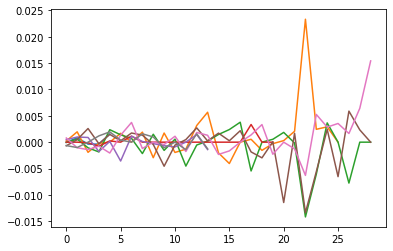

In [44]:
for i in range(n_trtype):
    #print(np.abs(search_l1_all[i].best_estimator_['clf'].coef_))
    print(np.sum(np.abs(search_8x1[i].best_estimator_['clf'].coef_)>0.5e-2))
    plt.plot(search_8x1[i].best_estimator_['clf'].coef_.T)

## Things to try
- Use non-linear methods like kernel methods (but we are already overfitting)
- Craft our own Quadratic Discriminant Analysis with diagonal cov matrices
- Use L1 penalty + logistic regression (highly relevant to find a relevant low dimensional space)
- Use brute force PCA components selection (using all intervals [i,j])
- do channel selection and time windows selection